In [16]:
%matplotlib inline
import os
import cv2
import csv
import time
import numpy as np
from numpy import array
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.parser import CParserError
import nltk
from nltk.tokenize import word_tokenize, WordPunctTokenizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize.treebank import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer 
from nltk.stem.porter import PorterStemmer
import gensim
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from sklearn.cluster import KMeans
from PIL import Image
from pylab import *

In [2]:
# Read outfits data

outfits_df = pd.read_csv("outfits.csv")
outfits_df = outfits_df.drop(["link", "image", "author", "views", "likes", "description", "similar1", "similar2", "similar3", "similar4", "similar5"], axis=1)
outfits_df = outfits_df.rename(columns={"title": "outfit_title"})
outfits_df = outfits_df.sort_values('outfit_id').reset_index(drop=True)

outfits_df

,outfit_id,outfit_title,create_date
0,2281409,Holy Frijoles!,20170914
1,192712867,Stay True!,20160307
2,192712937,Style #9906,20160307
3,192712989,Orange Sets 16,20160307
4,192713072,Bag Style: Tweed,20160307
5,192713239,ZAFUL #3 05.03,20160307
6,192713613,"Ya Rayah, Rachid Taha",20160307
7,192713940,Style #9907,20160307
8,192714043,Untitled #3872,20160307
9,192714072,Omg,20160307


In [3]:
# Read items data

items_df = pd.read_csv("items.csv")
items_df = items_df.drop(["link", "image", "category1_id", "category1_name", "category2_id", "category3_id", "category4_id", "brand", "price", "likes"], axis=1)
items_df = items_df.rename(columns={"title": "item_title"})

items_df

,item_id,item_title,category2_name,category3_name,category4_name,description,keyword1,keyword2,keyword3,keyword4,keyword5,keyword6
0,169037977,Sergio Rossi Godiva Shiny Metallic Leather Pump,Shoes,Pumps,Sergio Rossi pumps,"Shiny gold-tone metallic pumps with a 4 1/2"" h...",Sergio Rossi,High heeled footwear,Leather shoes,Metallic shoes,Pointy-toe pumps,Polish shoes
1,173221952,Jordan Askill Pink Glitter Enamel Heart Necklace,Jewelry,Necklaces,Jordan Askill necklaces,"A great complement to any style, this necklace...",Jordan Askill,Pink necklace,Rose necklace,Long necklace,Heart necklace,Enamel jewelry
2,159534875,RVCA Criton Crew Sweatshirt,Sweatshirts & Hoodies,Sweatshirts,RVCA sweatshirts,"The fire's crackling away, your fuzzy socks fe...",RVCA,Purple shirt,Crewneck sweatshirt,Low top,Crew shirt,Fuzzy sweatshirt
3,105330893,"Artist Crop Jeans, Women's, Size: 0, Medium De...",Jeans,Boyfriend Jeans,American Eagle Outfitters jeans,"Soft stretch cotton denim, Low 8"" front rise, ...",Cropped jeans,Blue jeans,Distressed jeans,Slim fit jeans,Destroyed jeans,Ripped boyfriend jeans
4,148723293,NOVICA Handmade Star Sterling Silver Signet Qu...,Jewelry,Rings,NOVICA rings,Telma Camargo de Araujo creates a spectacular ...,NOVICA,Sterling silver jewellery,Signet ring,Star jewelry,Quartz ring,Clear rings
5,172063387,Beach Babe Bikini in Crochet Print,Clothing,Swimwear,Bikinis,Beach Babe Bikini in Crochet Print,Beach wear,Crochet bikini,Print bikinis,Macrame bikini,Patterned bikini,NaN
6,172545089,Womens Sexy Lace Patchwork Short Sleeve Long B...,Clothing,Swimwear,Cover-ups,Order this Womens Sexy Lace Patchwork Short Sl...,Cover up swimwear,Sexy swimwear,White sarong,NaN,NaN,NaN
7,165338278,Yoins SLeeveless Back Cut Out Denim Midi Dress,Clothing,Dresses,NaN,"You're the best there is, you need a dress to ...",Cutout dresses,Sleeveless dress,Collar dress,Denim dress,Midi dress,Mid calf dresses
8,191532477,Paco Rabanne Cotton Twill Dress,Dresses,Day Dresses,Paco Rabanne dresses,Styled with a pointed collar and a ruffled hem...,Paco Rabanne,Slimming dresses,Blue dress,Belted dress,Slim fit dress,Textured dress
9,155721097,Yoins 3-Row Chain Bracelet,Jewelry,Bracelets & Bangles,NaN,"A sleek, stacked bracelet look that connects w...",Gold bangles,Chain jewelry,Polish jewelry,Stacked bangles,Party jewelry,NaN


In [4]:
# Read outfit_item links data

outfit_item_df = pd.read_csv("outfit_item.csv")
outfit_item_df = outfit_item_df.drop(["id"], axis=1)
outfit_item_df = outfit_item_df.sort_values('outfit_id').reset_index(drop=True)

outfit_item_df

,outfit_id,item_id
0,2281409,1135414
1,2281409,1318443
2,2281409,1776340
3,2281409,2193914
4,192712867,155669593
5,192712867,134087140
6,192712867,157165536
7,192712867,56042072
8,192712937,154939277
9,192712937,131215402


In [5]:
# Merge outfits and items

outfit_item_df = pd.merge(outfit_item_df, outfits_df)
outfit_item_df = pd.merge(outfit_item_df, items_df)
outfit_item_df = outfit_item_df.sort_values('outfit_id').reset_index(drop=True)

outfit_item_df

,outfit_id,item_id,outfit_title,create_date,item_title,category2_name,category3_name,category4_name,description,keyword1,keyword2,keyword3,keyword4,keyword5,keyword6
0,2281409,1135414,Holy Frijoles!,20170914,LD Tuttle Manioulator Sandals - 80342,Shoes,Sandals,LD Tuttle sandals,Luxe leather panels top modern stacked-heel sl...,NaN,NaN,NaN,NaN,NaN,NaN
1,2281409,1318443,Holy Frijoles!,20170914,MARC BY MARC JACOBS 'Totally Turnlock' Key Pou...,Bags,Wallets,Marc by Marc Jacobs wallets,Brown leather 'Luxury Group' wallet from Comme...,Marc by Marc Jacobs,Brown bag,Key pouch,Turn lock wallet,NaN,NaN
2,2281409,1776340,Holy Frijoles!,20170914,PacSun.com - Horizon Short,Clothing,Shorts,NaN,Description Speak your mind with this pink can...,PacSun,Short shorts,NaN,NaN,NaN,NaN
3,2281409,2193914,Holy Frijoles!,20170914,Womens Holy Frijoles Tee at PalmerCash.com,Clothing,Tops,T-Shirts,Grey cotton oversized cotton sweatpants from Y...,NaN,NaN,NaN,NaN,NaN,NaN
4,192712867,155669593,Stay True!,20160307,Kendra Scott Harlow Necklace (Gold Coral) Neck...,Jewelry,Necklaces,Kendra Scott necklaces,"Bold and dripping with audacious delight, this...",Kendra Scott,Gold pendant,Bib necklace,Chunky necklaces,Chain necklace,Pendant necklaces
5,192712867,134087140,Stay True!,20160307,Yoins Light Brick Envelope Clutch Bag With Tri...,Bags,Handbags,Clutches,The light brick clutch bag features triple loc...,Envelope clutch,Kiss-lock handbags,Locking purse,NaN,NaN,NaN
6,192712867,157165536,Stay True!,20160307,Gianvito Rossi Leopard Print Plexi Pumps,Shoes,Pumps,Gianvito Rossi pumps,These leopard print Gianvito Rossi 'Plexi Pump...,Gianvito Rossi,Black pumps,Pointy-toe pumps,Leopard pumps,Stiletto pumps,Heel pump
7,192712867,56042072,Stay True!,20160307,Rafael Cennamo Asymmetrical Strapless Gown (Bl...,Clothing,Dresses,Gowns,HIRSHLEIFERS is one of the country’s most cele...,Strapless dresses,Asymmetrical dress,Couture dresses,American dress,NaN,NaN
8,192712937,163095786,Style #9906,20160307,So Kate Camel Pumps,Shoes,Pumps,NaN,Gianvito Rossi's patent-leather pumps are time...,Heel pump,Camel shoes,NaN,NaN,NaN,NaN
9,192712937,165145385,Style #9906,20160307,Fitted Crop Top by Glamorous,Clothing,Tops,Topshop tops,up-the-ante on the crop with this fitted style...,Cropped shirts,Yellow top,Brown shirts,Crop top,Fitted shirts,Polyester shirt


In [6]:
%%time

# Concat outfit title, items title, items description, items keywords

articles = []
previous = ""
s = ""

for i in xrange(len(outfit_item_df)):
    if i > 0:
        previous = outfit_item_df.outfit_id[i-1]
    
#     print i
    
    outfit_id = outfit_item_df.outfit_id[i]
#     print outfit_id
    
    item_id = outfit_item_df.item_id[i]
#     print item_id
    
    outfit_title = outfit_item_df.outfit_title[i]
#     print outfit_title
    
    item_title = outfit_item_df.item_title[i]
#     print item_title

    item_category1 = str(outfit_item_df.category2_name[i])
    if item_category1 == "nan":
        item_category1 = ""
#     print item_category1
    
    item_category2 = str(outfit_item_df.category3_name[i])
    if item_category2 == "nan":
        item_category2 = ""
#     print item_category2
    
    item_category3 = str(outfit_item_df.category4_name[i])
    if item_category3 == "nan":
        item_category3 = ""
#     print item_category3
    
    item_description = str(outfit_item_df.description[i])
    if item_description == "nan":
        item_description = ""
#     print item_description
    
    item_keyword1 = str(outfit_item_df.keyword1[i])
    if item_keyword1 == "nan":
        item_keyword1 = ""
#     print item_keyword1
    
    item_keyword2 = str(outfit_item_df.keyword2[i])
    if item_keyword2 == "nan":
        item_keyword2 = ""
#     print item_keyword2
    
    item_keyword3 = str(outfit_item_df.keyword3[i])
    if item_keyword3 == "nan":
        item_keyword3 = ""
#     print item_keyword3
    
    item_keyword4 = str(outfit_item_df.keyword4[i])
    if item_keyword4 == "nan":
        item_keyword4 = ""
#     print item_keyword4
    
    item_keyword5 = str(outfit_item_df.keyword5[i])
    if item_keyword5 == "nan":
        item_keyword5 = ""
#     print item_keyword5
    
    item_keyword6 = str(outfit_item_df.keyword6[i])
    if item_keyword6 == "nan":
        item_keyword6 = ""
#     print item_keyword6

    
    if (outfit_id == previous):
        s = s +" "+ item_title +" "+ item_category1 +" "+ item_category2 +" "+ item_category3 +" "+ item_description +" "+ item_keyword1 +" "+ item_keyword2 +" "+ item_keyword3 +" "+ item_keyword4 +" "+ item_keyword5 +" "+ item_keyword6 
    else:
        if i > 0:
            articles.append(s)
        s = ""
        s = s +" "+ outfit_title +" "+ item_title +" "+ item_category1 +" "+ item_category2 +" "+ item_category3 +" "+ item_description +" "+ item_keyword1 +" "+ item_keyword2 +" "+ item_keyword3 +" "+ item_keyword4 +" "+ item_keyword5 +" "+ item_keyword6 
        
print len(articles)

126078
CPU times: user 4min 38s, sys: 4.99 s, total: 4min 43s
Wall time: 5min 6s


In [7]:
print articles[0]

 Holy Frijoles! LD Tuttle Manioulator Sandals - 80342 Shoes Sandals LD Tuttle sandals Luxe leather panels top modern stacked-heel slide Stacked heel, 1.5" (40mm) Leather upper Open toe Slip-on style Leather lining and sole Padded insole Made in Italy. Women's Shoes - Contemporary Womens Shoe. LD Tuttle. Color: Black,black,black,black,wax,wax,wax,wax.       MARC BY MARC JACOBS 'Totally Turnlock' Key Pouch - View All - Nordstrom Bags Wallets Marc by Marc Jacobs wallets Brown leather 'Luxury Group' wallet from Comme Des Garçons featuring an all around zip fastening, multiple interior card slots, a coin pocket and an internal logo stamp. This item is unisex. Gender: Unisex. Age Group: Adult. Material: Leather. Marc by Marc Jacobs Brown bag Key pouch Turn lock wallet   PacSun.com - Horizon Short Clothing Shorts  Description Speak your mind with this pink canvas clutch featuring a coin purse closure, beaded Who Runs The World? motif, and a gold chain strap.  100% Canvas.  Imported.  SAR36P78

In [8]:
%%time

# Remove stop words, tokenize, stemming

# Setting stop words
english_stopwords = stopwords.words('english')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

# Stem token
articles = [[p_stemmer.stem(word) for word in TreebankWordTokenizer().tokenize(description.lower()) if word.isalpha() and len(word) > 2 and word not in english_stopwords] for description in articles]

# articles = [[p_stemmer.stem(word) for word in description] for description in articles]

CPU times: user 46min 47s, sys: 58 s, total: 47min 45s
Wall time: 57min 5s


In [9]:
print articles[0]

[u'holi', u'frijol', u'tuttl', u'manioul', u'sandal', u'shoe', u'sandal', u'tuttl', u'sandal', u'lux', 'leather', u'panel', 'top', 'modern', 'slide', u'stack', 'heel', 'leather', 'upper', 'open', 'toe', 'style', 'leather', u'line', 'sole', u'pad', u'insol', 'made', 'women', u'shoe', u'contemporari', u'women', 'color', 'black', 'black', 'black', 'black', 'wax', 'wax', 'wax', 'marc', 'marc', u'jacob', 'turnlock', 'key', 'pouch', 'view', 'nordstrom', u'bag', u'wallet', 'marc', 'marc', u'jacob', u'wallet', 'brown', 'leather', 'group', 'wallet', u'comm', u'de', u'featur', 'around', 'zip', u'fasten', u'multipl', 'interior', 'card', u'slot', 'coin', 'pocket', u'intern', 'logo', 'item', 'gender', 'age', 'group', u'materi', 'marc', 'marc', u'jacob', 'brown', 'bag', 'key', 'pouch', 'turn', 'lock', 'wallet', 'horizon', 'short', u'cloth', u'short', u'descript', 'speak', 'mind', 'pink', u'canva', 'clutch', u'featur', 'coin', u'purs', u'closur', u'bead', u'run', 'world', 'motif', 'gold', 'chain', 'p

In [10]:
%%time

# Constructing a document-term matrix

# Generate dictionary
dictionary = corpora.Dictionary(articles)

# Get rid of the words that appear in less than 50 documents or more than 10% documents
dictionary.filter_extremes(no_below=50, no_above=0.1)

dictionary.save('data/dictionary.dict')
# dictionary = corpora.Dictionary.load('data/dictionary.dict')

# converts dictionary into a bag-of-words
corpus = [dictionary.doc2bow(description) for description in articles]
corpora.MmCorpus.serialize('data/corpus.mm', corpus)

CPU times: user 1min 40s, sys: 8.27 s, total: 1min 49s
Wall time: 2min 3s


In [11]:
print corpus[0]

[(85, 2), (224, 1), (940, 1), (947, 1), (1758, 1), (2237, 3), (2500, 1), (2556, 1), (2682, 1), (2705, 3), (2845, 1), (2938, 1), (3368, 1), (3393, 1), (3731, 1), (3824, 1), (3960, 1), (4127, 1), (4137, 2), (4584, 1), (4996, 4), (5206, 1), (5281, 6), (5320, 1), (5467, 1), (5886, 1), (5939, 2), (6382, 1), (6623, 2), (6878, 1), (7158, 1), (7265, 1), (7405, 1), (7662, 1), (7693, 1), (8452, 1)]


In [12]:
# initialize a tfidf model
tfidf = models.TfidfModel(corpus)

# use the model to transform vectors, apply a transformation to a whole corpus
corpus_tfidf = tfidf[corpus]

CPU times: user 4.17 s, sys: 33 ms, total: 4.2 s
Wall time: 4.32 s


In [13]:
print corpus_tfidf[0]

[(85, 0.3432585034559989), (224, 0.06482116828893898), (940, 0.05683414285645281), (947, 0.0841429439019036), (1758, 0.06777086295175269), (2237, 0.2694730232758602), (2500, 0.11749238776226505), (2556, 0.12177676666374605), (2682, 0.1531175563089053), (2705, 0.3730540921740804), (2845, 0.07086474472313434), (2938, 0.06297825688183224), (3368, 0.11857408898295232), (3393, 0.12891019472374068), (3731, 0.07584904792941034), (3824, 0.08001502817991181), (3960, 0.08023353319035113), (4127, 0.06990310147999089), (4137, 0.1309427609584891), (4584, 0.10729103577800965), (4996, 0.3146135290604905), (5206, 0.06255768865203125), (5281, 0.525920125869104), (5320, 0.05425709470100064), (5467, 0.0799749997027674), (5886, 0.063606695392326), (5939, 0.1811727512200656), (6382, 0.06223782283202447), (6623, 0.1362373819094641), (6878, 0.05725286097967345), (7158, 0.12854017324263878), (7265, 0.07419995437219268), (7405, 0.1302042439471357), (7662, 0.057545701253856565), (7693, 0.07135691596217618), (84

In [19]:
num_topics = [20, 25, 30]
iterations = [100, 300, 500]

# Applying the LDA model
for i in num_topics:
    for j in iterations:
        print str(i)+"topics, "+str(j)+"iterations"
        
        %time lda = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=i, iterations=j)
        lda.save('data/lda_'+str(i)+'topics_'+str(j)+'iterations.model')
        
        print CoherenceModel(model=lda, corpus=corpus_tfidf, dictionary=dictionary, coherence='u_mass').get_coherence()
        print CoherenceModel(model=lda, texts=articles, dictionary=dictionary, coherence='c_v').get_coherence()
        print "\n"

20topics, 100iterations
CPU times: user 4min 16s, sys: 9.27 s, total: 4min 25s
Wall time: 4min 46s
-5.819203331669136
0.33800764569872094


20topics, 300iterations
CPU times: user 4min 8s, sys: 7.73 s, total: 4min 16s
Wall time: 4min 34s
-6.2468259319289094
0.3533269234523974


20topics, 500iterations
CPU times: user 4min 21s, sys: 13 s, total: 4min 34s
Wall time: 5min 4s
-5.475718967660572
0.34868357099764424


25topics, 100iterations
CPU times: user 4min 2s, sys: 7.56 s, total: 4min 10s
Wall time: 4min 25s
-6.366753309038819
0.37175344361153356


25topics, 300iterations
CPU times: user 4min 47s, sys: 14.8 s, total: 5min 2s
Wall time: 6min 24s
-7.164197509155692
0.36684194515204266


25topics, 500iterations
CPU times: user 3min 55s, sys: 6.34 s, total: 4min 2s
Wall time: 4min 10s
-6.091715104898424
0.36281087848464616


30topics, 100iterations
CPU times: user 3min 51s, sys: 3.81 s, total: 3min 54s
Wall time: 3min 58s
-6.733411336388257
0.3735801758566659


30topics, 300iterations
CPU 

In [48]:
# Load outfit clustering LDA model
lda = gensim.models.LdaModel.load('data/lda_25topics_100iterations.model')
lda.print_topics(25)

[(0,
  u'0.016*"dolc" + 0.015*"gabbana" + 0.012*"christma" + 0.011*"oscar" + 0.010*"gown" + 0.010*"renta" + 0.009*"sequin" + 0.008*"giusepp" + 0.008*"zanotti" + 0.006*"parti"'),
 (1,
  u'0.047*"lauren" + 0.035*"spade" + 0.034*"ralph" + 0.029*"kate" + 0.022*"karl" + 0.020*"vinc" + 0.020*"lagerfeld" + 0.016*"camuto" + 0.016*"mankind" + 0.015*"rocha"'),
 (2,
  u'0.036*"michael" + 0.022*"kor" + 0.009*"simpson" + 0.008*"jessica" + 0.007*"widest" + 0.007*"deliveri" + 0.006*"skool" + 0.006*"pirat" + 0.006*"disney" + 0.006*"locket"'),
 (3,
  u'0.076*"watch" + 0.020*"stainless" + 0.019*"steel" + 0.018*"tori" + 0.017*"dial" + 0.017*"burch" + 0.015*"resist" + 0.013*"water" + 0.013*"quartz" + 0.009*"movement"'),
 (4,
  u'0.023*"blade" + 0.016*"iro" + 0.014*"loafer" + 0.013*"casadei" + 0.011*"bliss" + 0.011*"vian" + 0.011*"cluse" + 0.010*"mischief" + 0.009*"folli" + 0.009*"dakota"'),
 (5,
  u'0.019*"chanel" + 0.009*"david" + 0.008*"yurman" + 0.007*"quilt" + 0.006*"aso" + 0.006*"stuart" + 0.005*"wei

In [26]:
outfit_style_df = outfits_df
outfit_style_df["style"] = ""

outfit_style_df

,outfit_id,outfit_title,create_date,style
0,2281409,Holy Frijoles!,20170914,
1,192712867,Stay True!,20160307,
2,192712937,Style #9906,20160307,
3,192712989,Orange Sets 16,20160307,
4,192713072,Bag Style: Tweed,20160307,
5,192713239,ZAFUL #3 05.03,20160307,
6,192713613,"Ya Rayah, Rachid Taha",20160307,
7,192713940,Style #9907,20160307,
8,192714043,Untitled #3872,20160307,
9,192714072,Omg,20160307,


In [101]:
for i in xrange(len(corpus_tfidf)):
    topic_sim = lda.get_document_topics(corpus_tfidf[i])
    topic_sim = sorted(topic_sim, key=lambda x: x[1], reverse=True)
    
    outfit_style_df.loc[0,'style'] = topic_sim[0][0]
    
outfit_style_df

,outfit_id,outfit_title,create_date,style
0,2281409,Holy Frijoles!,20170914,23
1,192712867,Stay True!,20160307,0
2,192712937,Style #9906,20160307,23
3,192712989,Orange Sets 16,20160307,23
4,192713072,Bag Style: Tweed,20160307,12
5,192713239,ZAFUL #3 05.03,20160307,10
6,192713613,"Ya Rayah, Rachid Taha",20160307,12
7,192713940,Style #9907,20160307,23
8,192714043,Untitled #3872,20160307,5
9,192714072,Omg,20160307,7


In [102]:
# Write new csv to store outfit style
outfit_style_df.to_csv('outfit_style.csv', encoding='utf-8', index=False)

In [103]:
outfit_item_style_df = pd.merge(outfit_item_df, outfit_style_df)

outfit_item_style_df

,outfit_id,item_id,outfit_title,create_date,item_title,category2_name,category3_name,category4_name,description,keyword1,keyword2,keyword3,keyword4,keyword5,keyword6,style
0,2281409,1135414,Holy Frijoles!,20170914,LD Tuttle Manioulator Sandals - 80342,Shoes,Sandals,LD Tuttle sandals,Luxe leather panels top modern stacked-heel sl...,NaN,NaN,NaN,NaN,NaN,NaN,23
1,2281409,1318443,Holy Frijoles!,20170914,MARC BY MARC JACOBS 'Totally Turnlock' Key Pou...,Bags,Wallets,Marc by Marc Jacobs wallets,Brown leather 'Luxury Group' wallet from Comme...,Marc by Marc Jacobs,Brown bag,Key pouch,Turn lock wallet,NaN,NaN,23
2,2281409,1776340,Holy Frijoles!,20170914,PacSun.com - Horizon Short,Clothing,Shorts,NaN,Description Speak your mind with this pink can...,PacSun,Short shorts,NaN,NaN,NaN,NaN,23
3,2281409,2193914,Holy Frijoles!,20170914,Womens Holy Frijoles Tee at PalmerCash.com,Clothing,Tops,T-Shirts,Grey cotton oversized cotton sweatpants from Y...,NaN,NaN,NaN,NaN,NaN,NaN,23
4,192712867,155669593,Stay True!,20160307,Kendra Scott Harlow Necklace (Gold Coral) Neck...,Jewelry,Necklaces,Kendra Scott necklaces,"Bold and dripping with audacious delight, this...",Kendra Scott,Gold pendant,Bib necklace,Chunky necklaces,Chain necklace,Pendant necklaces,0
5,192712867,134087140,Stay True!,20160307,Yoins Light Brick Envelope Clutch Bag With Tri...,Bags,Handbags,Clutches,The light brick clutch bag features triple loc...,Envelope clutch,Kiss-lock handbags,Locking purse,NaN,NaN,NaN,0
6,192712867,157165536,Stay True!,20160307,Gianvito Rossi Leopard Print Plexi Pumps,Shoes,Pumps,Gianvito Rossi pumps,These leopard print Gianvito Rossi 'Plexi Pump...,Gianvito Rossi,Black pumps,Pointy-toe pumps,Leopard pumps,Stiletto pumps,Heel pump,0
7,192712867,56042072,Stay True!,20160307,Rafael Cennamo Asymmetrical Strapless Gown (Bl...,Clothing,Dresses,Gowns,HIRSHLEIFERS is one of the country’s most cele...,Strapless dresses,Asymmetrical dress,Couture dresses,American dress,NaN,NaN,0
8,192712937,163095786,Style #9906,20160307,So Kate Camel Pumps,Shoes,Pumps,NaN,Gianvito Rossi's patent-leather pumps are time...,Heel pump,Camel shoes,NaN,NaN,NaN,NaN,23
9,192712937,165145385,Style #9906,20160307,Fitted Crop Top by Glamorous,Clothing,Tops,Topshop tops,up-the-ante on the crop with this fitted style...,Cropped shirts,Yellow top,Brown shirts,Crop top,Fitted shirts,Polyester shirt,23


In [104]:
# Write new csv to store outfit style
outfit_item_style_df.to_csv('outfit_item_style.csv', encoding='utf-8', index=False)

In [143]:
style_outfits = []
style_items = []

# Initialize
for i in xrange(25):
    style_outfits.append(set())
    style_items.append(set())

# Store outfits and items into style list
for i in xrange(len(outfit_item_style_df)):

    style = outfit_item_style_df.loc[i,'style']
    
    if style != "":
        style_outfits[style].add(outfit_item_style_df.loc[i,'outfit_id'])
        style_items[style].add(outfit_item_style_df.loc[i,'item_id'])


In [151]:
# Save the style outfits and items into a txt file
for i in xrange(25):
    
    print "Style " + str(i)
    print "# of Outfits: " + str(len(style_outfits[i]))
    print "# of Items: " + str(len(style_items[i]))
    
    f = open("style/style" + str(i) + "_outfits.txt", "w")
    f.write("\n".join(map(lambda x: str(x), style_outfits[i])))
    f.close()
    
    f = open("style/style" + str(i) + "_items.txt", "w")
    f.write("\n".join(map(lambda x: str(x), style_items[i])))
    f.close()
    

Style 0
# of Outfits: 10485
# of Items: 41124
Style 1
# of Outfits: 64
# of Items: 268
Style 2
# of Outfits: 1076
# of Items: 4857
Style 3
# of Outfits: 2653
# of Items: 13049
Style 4
# of Outfits: 195
# of Items: 726
Style 5
# of Outfits: 5430
# of Items: 24117
Style 6
# of Outfits: 2196
# of Items: 9356
Style 7
# of Outfits: 1496
# of Items: 6819
Style 8
# of Outfits: 6131
# of Items: 22526
Style 9
# of Outfits: 309
# of Items: 1242
Style 10
# of Outfits: 3330
# of Items: 12835
Style 11
# of Outfits: 2694
# of Items: 10988
Style 12
# of Outfits: 31091
# of Items: 110485
Style 13
# of Outfits: 40
# of Items: 181
Style 14
# of Outfits: 6844
# of Items: 29194
Style 15
# of Outfits: 332
# of Items: 1458
Style 16
# of Outfits: 264
# of Items: 1133
Style 17
# of Outfits: 204
# of Items: 719
Style 18
# of Outfits: 628
# of Items: 2590
Style 19
# of Outfits: 656
# of Items: 2340
Style 20
# of Outfits: 43
# of Items: 133
Style 21
# of Outfits: 948
# of Items: 3682
Style 22
# of Outfits: 47
# 

In [81]:
# Find the topics using pyLDAvis
import pyLDAvis.gensim as gensimvis
import pyLDAvis

# Visualize
vis_data = gensimvis.prepare(lda, corpus_tfidf, dictionary)
pyLDAvis.display(vis_data)

/Users/michellechen/anaconda2/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


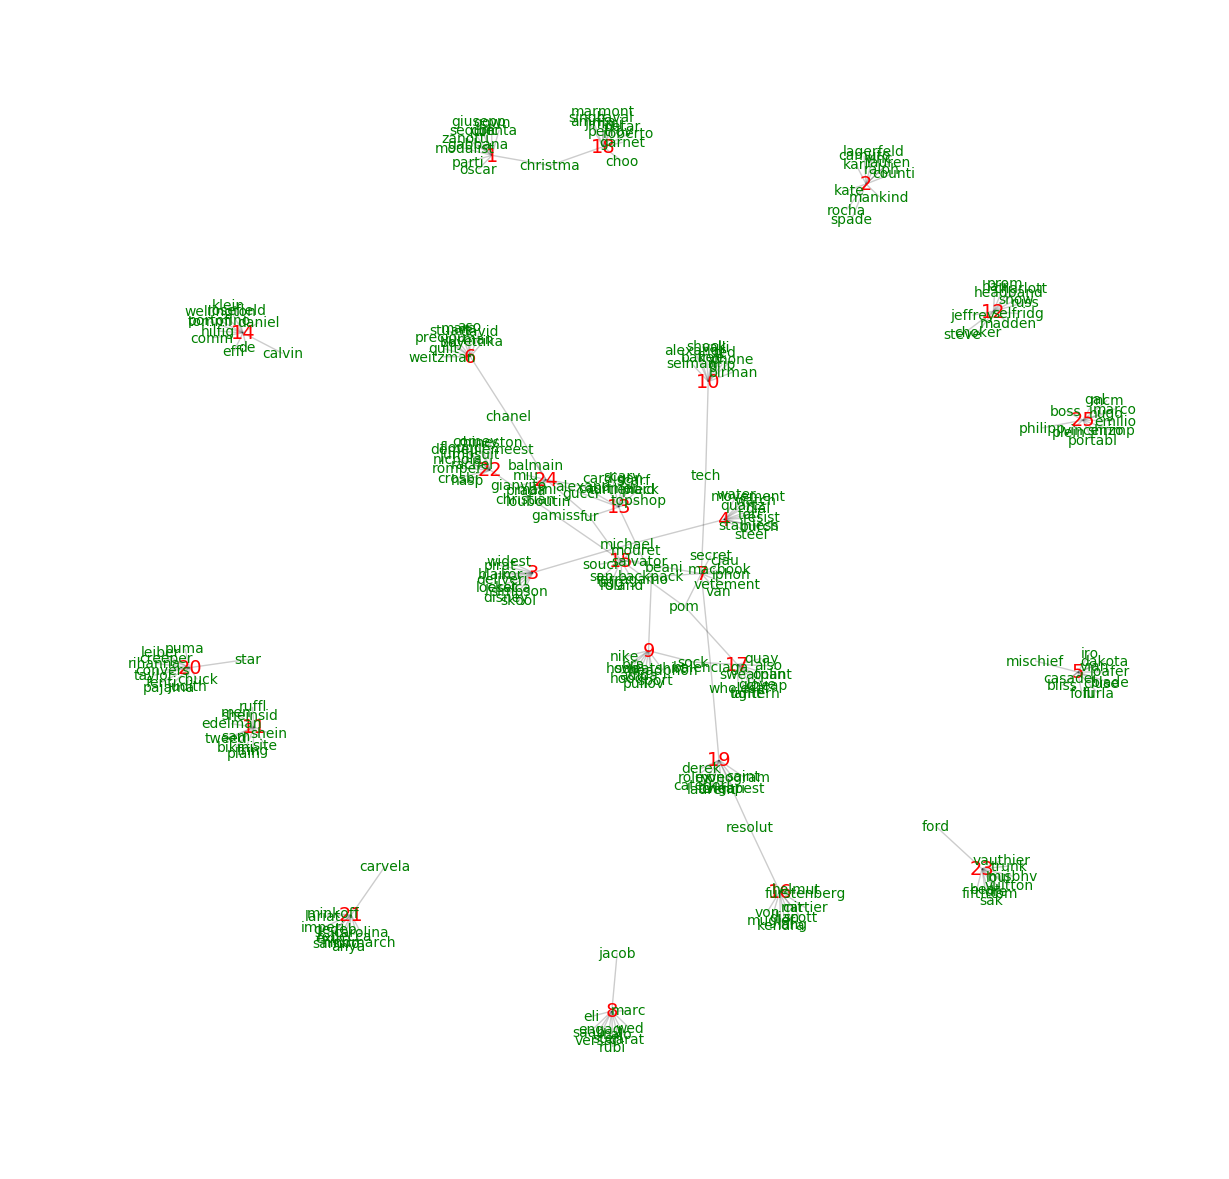

In [83]:
# View the network of topics and terms
import networkx as nx

t = []
topic_num = 25

def graph_terms_to_topics(lda, num_terms):
    # Topic names
    for i in range(topic_num):
        t.append(str(i+1))
    
    # Create a new graph and size it
    G = nx.Graph()
    plt.figure(figsize=(15,15))
    
    # Generate the edges
    for i in range(0, lda.num_topics):
        topicLabel = t[i]
        terms = [term for term, val in lda.show_topic(i, num_terms+1)]
        for term in terms:
            G.add_edge(topicLabel, term, edge_color='red')
    
    pos = nx.spring_layout(G) # positions for all nodes
    
    # Plot topic labels and terms labels separately to have different colours
    g = G.subgraph([topic for topic, _ in pos.items() if topic in t])
    nx.draw_networkx_labels(g, pos, font_size=14, font_color='red')
    g = G.subgraph([term for term, _ in pos.items() if str(term) not in t])
    nx.draw_networkx_labels(g, pos, font_size=10, font_color='green')
    
    # Plot edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), alpha=0.2)

    plt.axis('off')
    plt.show()

graph_terms_to_topics(lda, num_terms=10)

In [121]:
# predict query data

query = "sport"
query_bow = dictionary.doc2bow(query.lower().split())

for index, score in sorted(lda[query_bow], key=lambda tup: -1*tup[1]):
    print "Score: {}\nTopic: {}".format(score, lda.print_topic(index, 10))
    print "\n"

Score: 0.516666666666
Topic: 0.071*"shirt" + 0.060*"sneaker" + 0.036*"jean" + 0.026*"white" + 0.021*"coat" + 0.019*"sleev" + 0.017*"crop" + 0.016*"convers" + 0.016*"blue" + 0.014*"women"


Score: 0.016666666667
Topic: 0.067*"sweater" + 0.047*"sunglass" + 0.027*"jean" + 0.022*"sneaker" + 0.019*"leather" + 0.019*"glass" + 0.018*"adida" + 0.018*"end" + 0.016*"shirt" + 0.016*"land"


Score: 0.0166666666667
Topic: 0.244*"short" + 0.060*"backpack" + 0.059*"shirt" + 0.028*"denim" + 0.022*"crop" + 0.017*"tank" + 0.016*"white" + 0.013*"flat" + 0.011*"pack" + 0.011*"blue"


Score: 0.0166666666667
Topic: 0.106*"jewelri" + 0.097*"bracelet" + 0.065*"bangl" + 0.046*"michael" + 0.035*"kor" + 0.023*"shirt" + 0.020*"jewelleri" + 0.016*"blue" + 0.015*"gold" + 0.015*"watch"


Score: 0.0166666666667
Topic: 0.240*"jacket" + 0.047*"bra" + 0.029*"outerwear" + 0.019*"leather" + 0.019*"stella" + 0.018*"mccartney" + 0.016*"bomber" + 0.015*"lingeri" + 0.015*"blue" + 0.014*"jewelri"


Score: 0.0166666666667
Topic

In [68]:
index = similarities.MatrixSimilarity(lsi[corpus])

In [69]:
query = "sports" 
query_bow = dictionary.doc2bow(query.lower().split()) 
query_lsi = lsi[query_bow]
sims = index[query_lsi]
sort_sims = sorted(enumerate(sims), key=lambda item: -item[1]) 
print sort_sims[0:10]

[(912, 0.9035219), (10810, 0.89665681), (13253, 0.89394891), (9981, 0.88325703), (14969, 0.88221025), (20759, 0.88031703), (2010, 0.87053299), (3931, 0.8696028), (6355, 0.86820257), (5699, 0.85417181)]


In [72]:
print articles[912]

['black', 'ropmers', 'adidas', 'originals', 'suede', 'superstar', 'sneakers', 'shoes', 'sneakers', 'adidas', 'originals', 'suede', 'shoes', 'black', 'sneakers', 'lace', 'shoes', 'polish', 'shoes', 'striped', 'sneakers', 'givenchy', 'grainy', 'leather', 'backpack', 'bags', 'backpacks', 'givenchy', 'leather', 'bags', 'flap', 'backpack', 'urban', 'backpack', 'day', 'pack', 'backpack', 'pocket', 'backpack', 'givenchy', 'iphone', 'plus', 'stars', 'stripes', 'phone', 'case', 'accessories', 'tech', 'accessories', 'olivia', 'burton', 'women', 'winter', 'garden', 'leather', 'strap', 'watch', 'jewelry', 'watches', 'olivia', 'burton', 'watches', 'water', 'resistant', 'watches', 'flower', 'jewellery', 'leaf', 'jewelry', 'floral', 'jewellery']
